LSH Method

In [21]:
import numpy as np

X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
query_pt = np.array([7, 4])

def random_projections(X, query_pt, P):
    np.random.seed(35)
    R = np.random.randn(X.shape[1] + 1, P)  # +1 for the bias term
    X_proj = np.dot(np.hstack([X, np.ones((X.shape[0], 1))]), R)
    query_pt_proj = np.dot(np.hstack([query_pt, [1]]), R)
    return X_proj, query_pt_proj, R

def pairwise_dist_naive(x: np.ndarray, y: np.ndarray) -> float:
    """
    x: numpy array of shape (d,)
    y: numpy array of shape (d,)
    
    Returns the Euclidean distance between x and y
    """
    d = len(x)
    assert d == len(y)
    sqrd_distance = 0.0
    for i in range(d):
        sqrd_distance += (x[i] - y[i])**2
    return np.sqrt(sqrd_distance)

def distance_vector(X: np.ndarray, query_pt: np.ndarray) -> np.ndarray:
    """
    X: numpy array of shape (n, d)
    query_pt: numpy array of shape (d,)
    
    Returns the Euclidean distance between query_pt and each point in X
    """
    n, _ = X.shape
    distances = np.zeros(n)
    
    X_proj, query_pt_proj, R = random_projections(X, query_pt, P=3)    
    # Calculate Euclidean distance using the naive pairwise_dist_naive method
    for i in range(n):
        distances[i] = pairwise_dist_naive(X_proj[i], query_pt_proj)
    
    # Find the index of the point with the minimum distance
    nearest_neighbor_index = np.argmin(distances)
    
    return distances, nearest_neighbor_index, R

distances, nearest_neighbor_index, R = distance_vector(X, query_pt)
nearest_neighbor = X[nearest_neighbor_index]
print("Distances:", distances)
print("Nearest Neighbor:", nearest_neighbor)


Distances: [11.8692449  11.35438572 10.07896802  7.73010587  4.16123019  6.85298446
  3.75413783  8.62803158  9.38534457  6.71931202]
Nearest Neighbor: [7 2]


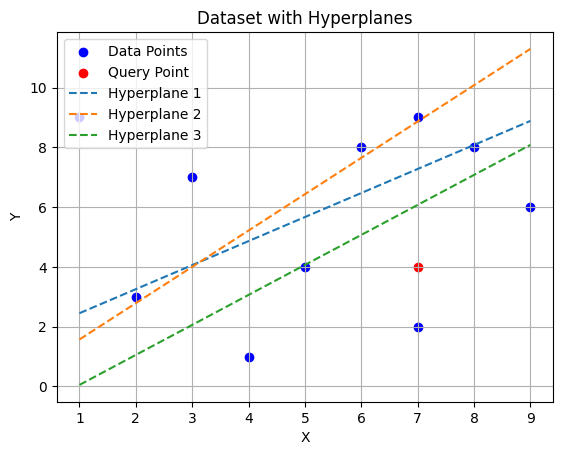

In [22]:
import matplotlib.pyplot as plt

def plot_dataset_with_hyperplanes(X: np.ndarray, R: np.ndarray):
    """
    X: numpy array of shape (n, d)
    R: Random projection matrix of shape (d+1, P)
    
    Plots the dataset along with the hyperplanes created by random projection.
    """
    plt.scatter(X[:, 0], X[:, 1], color='blue', label='Data Points')
    plt.scatter(query_pt[0], query_pt[1], color='red', label='Query Point')


    for i in range(R.shape[1]):
        x1 = np.array([min(X[:, 0]), max(X[:, 0])])
        x2 = (-R[0, i] - R[1, i]*x1) / R[2, i]
        plt.plot(x1, x2, linestyle='--', label=f'Hyperplane {i+1}')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Dataset with Hyperplanes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot dataset with hyperplanes
plot_dataset_with_hyperplanes(X, R)


KD Tree

In [23]:
import numpy as np
from sklearn.neighbors import KDTree

X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
query_pt = np.array([7, 4])

def pairwise_dist_naive(x: np.ndarray, y: np.ndarray) -> float:
    """
    x: numpy array of shape (d,)
    y: numpy array of shape (d,)
    
    Returns the Euclidean distance between x and y
    """
    d = len(x)
    assert d == len(y), "Vectors must be of the same dimension"
    sqrd_distance = 0.0
    for i in range(d):
        sqrd_distance += (x[i] - y[i])**2
    return np.sqrt(sqrd_distance)

def distance_vector_new(X: np.ndarray, query_pt: np.ndarray) -> np.ndarray:
    """
    X: numpy array of shape (n, d)
    query_pt: numpy array of shape (d,)
    
    Returns the Euclidean distance between query_pt and each point in X using a naive approach
    """
    n, d = X.shape
    distances = np.zeros(n)
    
    for i in range(n):
        distances[i] = pairwise_dist_naive(X[i], query_pt)
    
    return distances

def nearest_neighbor_kdtree(X: np.ndarray, query_pt: np.ndarray) -> np.ndarray:
    """
    X: numpy array of shape (n, d)
    query_pt: numpy array of shape (d,)
    
    Returns the index of the nearest neighbor in X to the query point using KD Tree
    """
    kdtree = KDTree(X, leaf_size=30, metric='euclidean')
    dist, ind = kdtree.query([query_pt], k=1)
    return ind[0]

# Calculate distances using direct computation with for-loop
distances_direct = distance_vector_new(X, query_pt)

# Find nearest neighbor index using KD Tree
nearest_neighbor_index = nearest_neighbor_kdtree(X, query_pt)
nearest_neighbor_point = X[nearest_neighbor_index]

print("Direct Distances:", distances_direct)
print("Nearest Neighbor Index (KD Tree):", nearest_neighbor_index)
print("Nearest Neighbor Point:", nearest_neighbor_point)


Direct Distances: [7.81024968 5.09901951 4.24264069 5.         2.         4.12310563
 2.         4.12310563 5.         2.82842712]
Nearest Neighbor Index (KD Tree): [4]
Nearest Neighbor Point: [[5 4]]


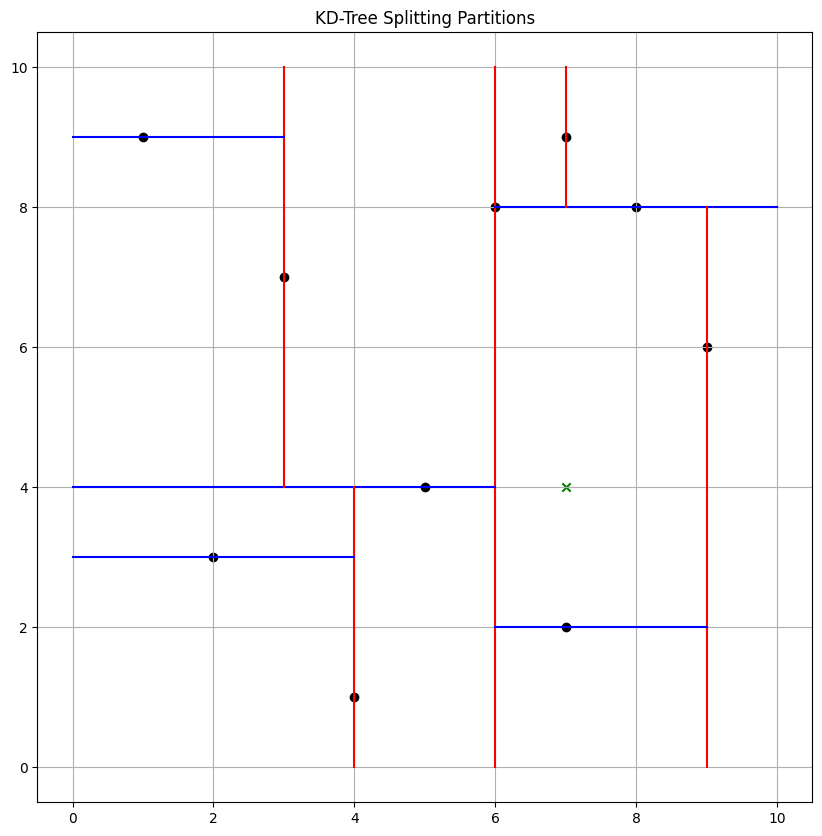

In [24]:
import numpy as np

X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
query_pt = np.array([7, 4])

class KDNode:
    def __init__(self, point, left=None, right=None):
        self.point = point
        self.left = left
        self.right = right

def build_kdtree(points, depth=0):
    n = len(points)
    if n == 0:
        return None

    k = len(points[0])  # assumes all points have the same dimension
    axis = depth % k

    # Sort point array and choose median as pivot element
    sorted_points = sorted(points, key=lambda point: point[axis])
    median_index = n // 2

    # Create node and recursively construct subtrees
    return KDNode(
        point=sorted_points[median_index],
        left=build_kdtree(sorted_points[:median_index], depth + 1),
        right=build_kdtree(sorted_points[median_index + 1:], depth + 1)
    )

# Build KD-Tree
kd_tree = build_kdtree(X)

import matplotlib.pyplot as plt

def plot_kdtree(node, min_x, max_x, min_y, max_y, depth=0):
    if node is not None:
        # Determine axis and draw the line
        k = len(node.point)
        axis = depth % k

        if axis == 0:
            plt.plot([node.point[0], node.point[0]], [min_y, max_y], 'r-')
            plot_kdtree(node.left, min_x, node.point[0], min_y, max_y, depth + 1)
            plot_kdtree(node.right, node.point[0], max_x, min_y, max_y, depth + 1)
        else:
            plt.plot([min_x, max_x], [node.point[1], node.point[1]], 'b-')
            plot_kdtree(node.left, min_x, max_x, min_y, node.point[1], depth + 1)
            plot_kdtree(node.right, min_x, max_x, node.point[1], max_y, depth + 1)

# Plot points and query point
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c='k')
plt.scatter(query_pt[0], query_pt[1], c='g', marker='x')  # query point in green

# Call the function with initial bounds
plot_kdtree(kd_tree, min(X[:, 0])-1, max(X[:, 0])+1, min(X[:, 1])-1, max(X[:, 1])+1)

plt.grid(True)
plt.title('KD-Tree Splitting Partitions')
plt.show()


In [25]:
def pairwise_dist_naive(x: np.ndarray, y: np.ndarray) -> float:
    """
    x: numpy array of shape (d,)
    y: numpy array of shape (d,)
    
    Returns the Euclidean distance between x and y
    """
    d = len(x)
    assert d == len(y), "Vectors must be of the same dimension"
    sqrd_distance = 0.0
    for i in range(d):
        sqrd_distance += (x[i] - y[i])**2
    return np.sqrt(sqrd_distance)

def find_nearest(node, point, depth=0, best=None):
    if node is None:
        return best

    # Determine the current axis
    k = len(point)
    axis = depth % k

    # Update the best if the current node is closer
    current_distance = pairwise_dist_naive(np.array(node.point), np.array(point))
    if best is None or current_distance < pairwise_dist_naive(np.array(best.point), np.array(point)):
        best = node

    # Determine whether to go left or right in the tree
    next_branch = None
    opposite_branch = None
    if point[axis] < node.point[axis]:
        next_branch = node.left
        opposite_branch = node.right
    else:
        next_branch = node.right
        opposite_branch = node.left

    # Search the next branch
    best = find_nearest(next_branch, point, depth + 1, best)

    # Check if we need to check the opposite side
    if (point[axis] - node.point[axis])**2 < pairwise_dist_naive(np.array(best.point), np.array(point))**2:
        best = find_nearest(opposite_branch, point, depth + 1, best)

    return best
# Assuming kd_tree is the root of your KD-Tree
nearest_neighbor = find_nearest(kd_tree, query_pt)
if nearest_neighbor is not None:
    print("Nearest neighbor:", nearest_neighbor.point)
else:
    print("No nearest neighbor found.")


Nearest neighbor: [7 2]


Naive Method

In [26]:
import numpy as np

X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
query_pt = np.array([7, 4])

def pairwise_dist_naive(x: np.ndarray, y: np.ndarray) -> float:
    """
    x: numpy array of shape (d,)
    y: numpy array of shape (d,)
    
    Returns the Euclidean distance between x and y
    """
    d = len(x)
    assert d == len(y), "Vectors must be of the same dimension"
    sqrd_distance = 0.0
    for i in range(d):
        sqrd_distance += (x[i] - y[i])**2
    return np.sqrt(sqrd_distance)

def naive_knn(data, query, k):
    n = len(data)
    distances = np.zeros(n)
    
    # Calculate the Euclidean distance from the query point to all other points in the dataset using a for-loop
    for i in range(n):
        distances[i] = pairwise_dist_naive(data[i], query)
    
    # Get the indices of the sorted distances
    sorted_indices = np.argsort(distances)
    
    # Select the top k nearest neighbors
    nearest_neighbors = data[sorted_indices][:k]
    
    return nearest_neighbors

# Example usage
k = 1
nearest_neighbors = naive_knn(X, query_pt, k)
print("Nearest Neighbors:")
print(nearest_neighbors)


Nearest Neighbors:
[[5 4]]


#### Time and Memory Comparison

In [27]:
import numpy as np

def generate_dataset(N, D):
    # Generate random data
    return np.random.rand(N, D), np.random.rand(1, D)  # (data, query_point)

In [28]:
import time

def timed_execution(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    execution_time = end_time - start_time
    return result, execution_time

In [ ]:
import pandas as pd
from sklearn.neighbors import KDTree
import tracemalloc

results = []

# Varying dataset sizes and dimensions
Ns = [100, 500, 1000]  # Example sizes
Ds = [2, 5, 10]        # Example dimensions
k = 5                  # Number of neighbors

for N in Ns:
    for D in Ds:
        data, query_pt = generate_dataset(N, D)
        
        # Measure LSH
        tracemalloc.start()
        _, time_lsh = timed_execution(distance_vector, data, query_pt)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        memory_usage_lsh = peak / 1024**2  # Convert to MB

        # Measure KD-tree
        tracemalloc.start()
        _, time_kdtree = timed_execution(nearest_neighbor_kdtree, data, query_pt)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        memory_usage_kdtree = peak / 1024**2  # Convert to MB

        # Measure Naive method
        tracemalloc.start()
        _, time_naive = timed_execution(naive_knn, data, query_pt, k)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        memory_usage_naive = peak / 1024**2  # Convert to MB

        # Record results
        results.append({
            'N': N, 'D': D,
            'Time LSH (s)': time_lsh,
            'Memory LSH (MB)': memory_usage_lsh,
            'Time KD-Tree (s)': time_kdtree,
            'Memory KD-Tree (MB)': memory_usage_kdtree,
            'Time Naive (s)': time_naive,
            'Memory Naive (MB)': memory_usage_naive
        })

# Convert results to DataFrame for easier analysis
df = pd.DataFrame(results)
print(df)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting time taken by each KNN variant
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='N', y='Time LSH (s)', hue='D', marker='o', label='LSH')
sns.lineplot(data=df, x='N', y='Time KD-Tree (s)', hue='D', marker='s', label='KD-Tree')
sns.lineplot(data=df, x='N', y='Time Naive (s)', hue='D', marker='^', label='Naive')
plt.title('Time Comparison for Finding Nearest Neighbors')
plt.xlabel('Dataset Size (N)')
plt.ylabel('Time (s)')
plt.legend(title='Dimensions (D)')
plt.grid(True)
plt.show()

In [ ]:
# Plotting memory usage by each KNN variant
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='N', y='Memory LSH (MB)', hue='D', marker='o', label='LSH')
sns.lineplot(data=df, x='N', y='Memory KD-Tree (MB)', hue='D', marker='s', label='KD-Tree')
sns.lineplot(data=df, x='N', y='Memory Naive (MB)', hue='D', marker='^', label='Naive')
plt.title('Memory Usage Comparison for Finding Nearest Neighbors')
plt.xlabel('Dataset Size (N)')
plt.ylabel('Memory Usage (MB)')
plt.legend(title='Dimensions (D)')
plt.grid(True)
plt.show()